# Multicommodity Flows - World Food Programme example

The multicommodity network flow (MCNF) problem  is a canonical problem in the operations research literature. Before being able to implement robust versions of MCNFs, we need to learn its fundamental constraints. 

This demo looks at a World Food Program as it is deployed in Syria for food relief. We start by setting up our computational infrastructure. 
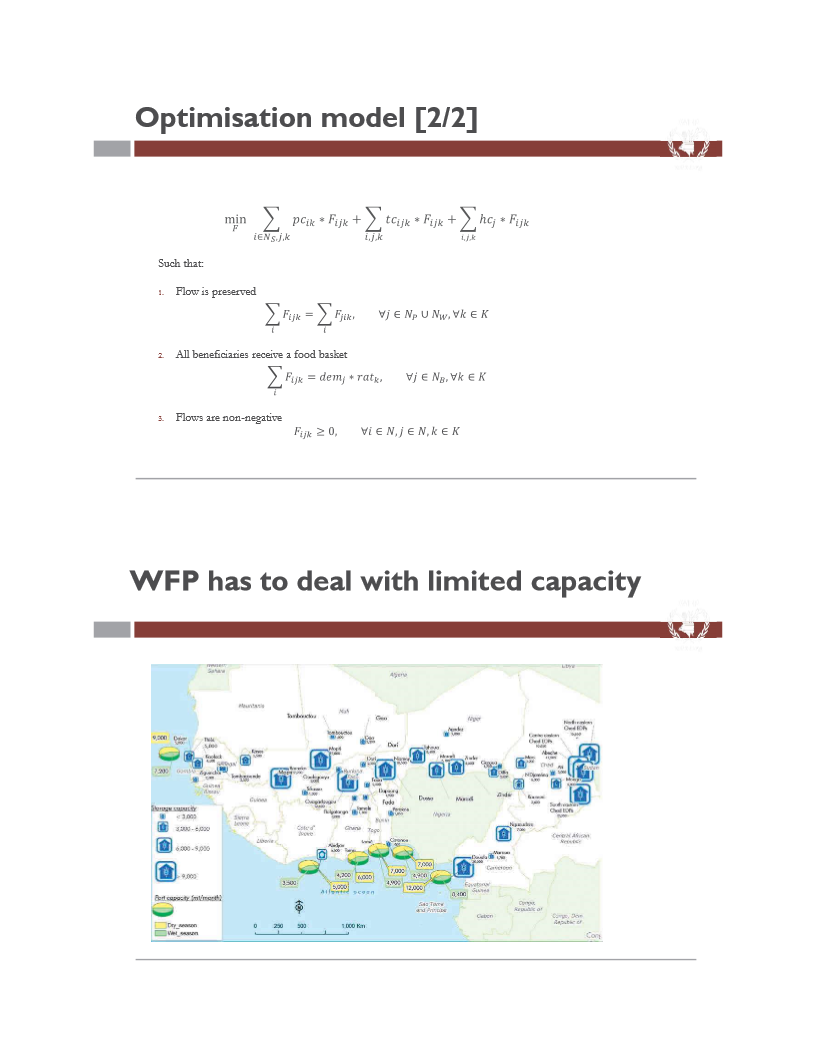

In [ ]:
# IMPORTS (to prepare for the steps ahead)
using Pkg
Pkg.activate(".")
using JuMP, Gurobi, Random, Distributions, LinearAlgebra, Plots, CSV, DataFrames

I import the relevant data, as it is presented in HW3 of the 15.094 Robust Optimization class of Spring 2021. Please feel free to dig into the individual items, which describe the different types of nodes in the problem, the edges, the commodities, their costs and requirements of each demand node. 

In [ ]:
# CRUNCHING THE DATA
# NODES (I = International supplier; R = Regional supplier; L = Local market (both supply and deliver); D = delivery point)
N = []
N_I = []     # set of international suppliers
N_R = []     # set of regional suppliers
N_L = []     # set of local markets
N_D = []     # delivery points
dem = Dict() # set of demands
file = CSV.File("../homeworks/HW3/syria_nodes.csv")
for row in file
    push!(N, row.Name)
    if !ismissing(row.Demand)
        dem[row.Name] = row.Demand
    end
    if row.Type == "I"
        push!(N_I, row.Name)
    elseif row.Type == "R"
        push!(N_R, row.Name)
    elseif row.Type == "L"
        push!(N_L, row.Name) # Note: local markets supply and deliver goods at the given cost. 
    elseif row.Type == "D"
        push!(N_D, row.Name)
    else
        throw(ErrorException("rowType $(row.Type) not supported."))
    end
end

# EDGES
hc = DataFrame(CSV.File("../homeworks/HW3/syria_edges.csv"))

# FOOD NUTRITION AND INTERNATIONAL COSTS
fooddata = DataFrame(CSV.File("../homeworks/HW3/syria_foodnutrition.csv"))
intfoodcosts = select(fooddata, [:Food, :InternationalPrice])
commodities = sort(Array(intfoodcosts.Food)) # Commodities
select!(fooddata, Not([14,15]))
fooddata = Dict(fooddata.Food .=> eachrow(fooddata)) 
# Note: fooddata contains the nutrients provided by 100g of a commodity!

# FOOD COST ($/metric ton for regional suppliers)
pc = DataFrame(CSV.File("../homeworks/HW3/syria_foodcost.csv"))
pc.Food = convert.(String63, pc.Food)
for int_supply_node in N_I # adding international prices to pc for easier processing
    for row in eachrow(intfoodcosts)
        append!(pc, DataFrame(:A => N_I, :Food => row.Food, :Price => row.InternationalPrice))
    end
end
pc = unique(pc)
international_items = DataFrame([r for r in eachrow(pc) if r.A in N_I])
regional_items =  DataFrame([r for r in eachrow(pc) if r.A in N_R])

# FOOD REQUIREMENTS (avg. per person per day)
foodreqs = DataFrame(CSV.File("../homeworks/HW3/syria_foodreq.csv"))
select!(foodreqs, Not(:Type))
nutrients = String.(propertynames(foodreqs))
foodreqs = Dict(string(pptname) => foodreqs[1, pptname] for pptname in propertynames(foodreqs))

## Looking at the data

Looking at the data is crucial for determining your variables and constraints. You learn:
- How many nodes, and types of nodes are present, and 
- How many edges are available for flow. 

Please make sure to acquiant yourself with the data below before proceeding to looking at the formulation. 

In [ ]:
# Look at data here. N, nutrients, commodities, hc, pc, fooddata, foodreqs.
N

## Optimization model creation

The primary constraints of the problem are as follows, from 10000 feet:
- Flow is preserved at all nodes. 
    - Additional sources at market nodes, N\N_D. 
    - Sinks at demand nodes N_D. 
- All demand nodes N_D receive a food basket.
- Flows are nonnegative on all edges.  
- Some nutritional constraints are satisfied. 

It is really important not to get too bogged down in the mathematical formulation.  
 Big picture recommendations, before demonstration:
- Start with low dimensional variables first, and build upwards. 
- Use auxiliary variables when intuitive and/or necessary. 
- Bonus: know some useful data structures (Pairs, Dicts, Arrays, DataFrames etc.).
- Don't be afraid to check constraints by printing out their LHS/RHS.
- Unbounded models are OK. However, it should be intuitive why they are unbounded. 
- Faulty models are REALLY hard to debug from results only. 
    - Use @asserts and other checks to make sure that elements of the code are right. 

In [ ]:
# FINALLY CREATING THE MODEL
m = Model(Gurobi.Optimizer)
set_optimizer_attribute(m, "OutputFlag", 0)

# START SIMPLE, with lower dimensional variables.

# Procurement and delivery (data structures)
procurement_links = unique([row.A => row.Food for row in eachrow(pc)])       # all places where we can procure food
@variable(m, procurement[A = N, Food = commodities; (A => Food) in procurement_links] >= 0) # procurement in tons
@variable(m, delivery[N_D, commodities] >= 0)                                               # delivery in tons

# Total procurement cost (check your vectors)
@variable(m, procurement_cost >= 0)
@constraint(m, procurement_cost == sum(r[:Price] * procurement[r.A, r.Food] for r in eachrow(pc)))

In [ ]:
# CREATE AUXILIARY VARIABLES when useful intuitively.

# Transportation
transportation_links = unique([row.A => row.B for row in eachrow(hc)]) # all possible UNIQUE edges
@variable(m, transportation[A = N, B = N; (A => B) in transportation_links] >= 0)     # transportation in tons...
@variable(m, F[A = N, B = N, W = commodities; (A => B) in transportation_links] >= 0) # linked directly to F, also in tons. 
for r in eachrow(hc) # Linking transportation cost to total food transported on an edge
    @constraint(m, transportation[r.A, r.B] == sum(F[r.A, r.B, commodity] for commodity in commodities))
end
# Total transportation cost
@variable(m, transportation_cost >= 0)
@constraint(m, transportation_cost == sum(r.tCost * transportation[r.A, r.B] for r in eachrow(hc)))

In [ ]:
# TAKE ADVANTAGE OF JuMP Dicts for loops!
# Flow constraints
for node in N
    valid_sources = [link.first for link in transportation_links if link.second == node]
    valid_sinks = [link.second for link in transportation_links if link.first == node]
    for commodity in commodities
        if (node =>  commodity) in procurement_links
            @constraint(m, procurement[node, commodity] + sum(F[source, node, commodity] for source in valid_sources) == 
                                sum(F[node, sink, commodity] for sink in valid_sinks))
        elseif node in N_D
            @assert length(valid_sinks) == 0
            @constraint(m, delivery[node, commodity] == sum(F[source, node, commodity] for source in valid_sources))
        else
            @constraint(m, sum(F[source, node, commodity] for source in valid_sources) == 
                                sum(F[node, sink, commodity] for sink in valid_sinks))
        end
    end
end

We have set up the commodity model, but we have yet to defined how many nutrients need to get to each beneficiary.  What we'd like to achieve is the optimal ratio of macro and micronutrients!

The micronutrients and caloric requirements are defined in ```foodreqs```. We first ensure that each recipient satisfies the nutritional requirements as defined. 


In [ ]:
# Serving demand
@variable(m, ration_pp[commodities] >= 0) # Rations (kg/person) of commodities
@variable(m, nutrients_pp[nutrients] >= 0) # Total nutrients per person

# Making sure the rations are good nutritionally (unit conversions!)
for nutrient in nutrients # Note the factor of 10 for conversion of 100g to kg (since rations are in kg/pp)
    @constraint(m, nutrients_pp[nutrient] == 10 * sum(ration_pp[commodity] * fooddata[commodity][nutrient] for commodity in commodities))
    @constraint(m, nutrients_pp[nutrient] >= foodreqs[nutrient])
end
for node in N_D
    for commodity in commodities
        @constraint(m, 1000*delivery[node, commodity] >= dem[node] * ration_pp[commodity])
    end
end

Now, we can set our objective to minimize total cost, solve our model, and take a look at food basket!

In [ ]:
# Setting objectives
@objective(m, Min, procurement_cost + transportation_cost)
optimize!(m)
Dict(commodities .=> Array(value.(ration_pp)))

Frankly, although this basket of foods satisfies the nutritional requirements, it seems unappetizing. Through careful examination, you would realize that the fat content (130g of oil!!) of this basket is way too high ; the macronutrient balance needs to be improved. So we add an additional set of diet constraints below, making sure to achieve a greater than 4:1 ratio by mass of carbohydrates to protein, and a greater than 4:1 ratio by mass of carbohydrates to fats. Let's see whether this changes our basket. 

In [ ]:
# Diet constraints
# for the same total energy intake. The energy stored in a gram of carbohydrate, protein and fat are 4kcal/g, 4kcal/g and 9kcal/g respectively. 
@variable(m, carbs_pp >= 0) # carbohydrates in grams/pp
@constraint(m, 4*carbs_pp == nutrients_pp["Energy(kcal)"] - 4*nutrients_pp["Protein(g)"] - 9*nutrients_pp["Fat(g)"])
@constraint(m, carbs_pp >= 4*nutrients_pp["Protein(g)"])
@constraint(m, carbs_pp >= 4*nutrients_pp["Fat(g)"])

In [ ]:
# Resolving, and showing the new and improved food basket. 
optimize!(m)
Dict(commodities .=> Array(value.(ration_pp)))

This basket looks much better! There is a greater diversity in commodities and the quantity of oils is reduced. Success! Please see ```robustMulticommodityFlows.ipynb``` for a robustification of this problem to uncertainty. ***Work in progress***. 